# Noisy thermal food processing surrogate evaluation

Evaluation of the models trained in `main.py`

In [2]:
import sys; sys.path.append('../../..')   # Allow relative imports from the parent folder
from pathlib import Path
import pandas as pd

import jax
import jax.random as jr

import numpy as np
import timeit

from main import get_results
from noisy_chicken_src.dataloader import prepare_data

from matplotlib import pyplot as plt


def get_statistics(array):
    """Get statistics such as interquartile mean and many more along the first axis of the array.

    Args:
        array (Array): Input array of data.

    Returns:
        dict: Dictionary of statistics including the oridinal array.
    """
    first_quartile, median, third_quartile = np.quantile(
        array, [0.25, 0.5, 0.75], axis=0, method="closest_observation"
    )
    # Compute the interquartile mean
    interquartile_mask = np.logical_and(
        first_quartile <= array, array <= third_quartile
    )
    interquartile_mean = np.nanmean(np.where(interquartile_mask, array, np.nan), axis=0)
    statistics = dict(
        values=array,
        max=np.max(array, axis=0),
        min=np.min(array, axis=0),
        mean=np.mean(array, axis=0),
        first_quartile=first_quartile,
        median=median,
        interquartile_mean=interquartile_mean,
        third_quartile=third_quartile,
        std=np.std(array, axis=0),
    )
    return statistics


print("WARNING: There is sommething wrong with the long data: T_A_long = T_B_long.")

Load the data and models

In [3]:
data, t_normalizer, y_normalizer, u_normalizer = prepare_data()

#  Get results and place them in a dataframe
results = get_results(Path(R".\results\run_0"), parallel=False)
df = pd.DataFrame(results)

# Rename the model cPHNN
df["model_type"] = df["model_type"].replace("cPHNN", "bPHNN")
# Make model name a categorical and define the default order
model_type_order = ["sPHNN", "sPHNN-LM", "bPHNN", "PHNN", "NODE"]
df["model_type"] = pd.Categorical(
    df["model_type"], categories=model_type_order, ordered=True
)
# Turn all arrays with shape () into float
df = df.map(lambda x: float(x) if isinstance(x, np.ndarray) and x.shape == () else x)
# Assert that the hyperparameters "num_aug" and "num_train_trajectories" are the same throughout
assert df["num_aug"].nunique() == 1, (
    "num_aug should be the same for all models for this evalutaion"
)
assert df["num_train_trajectories"].nunique() == 1, (
    "num_train_trajectories should be the same for all models for this evalutaion"
)

sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance:  0
sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance:  1
sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance:  2
sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance:  3
sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance:  4
sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance:  5
sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance:  6
sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance:  7
sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance:  8
sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance:  9
sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance: 10
sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance: 11
sPHNN-LM       , num_aug= 3, num_dat= 2, noise_amplitude=0.05, instance: 12
sPHNN-LM    

Plot the training data for different noise values

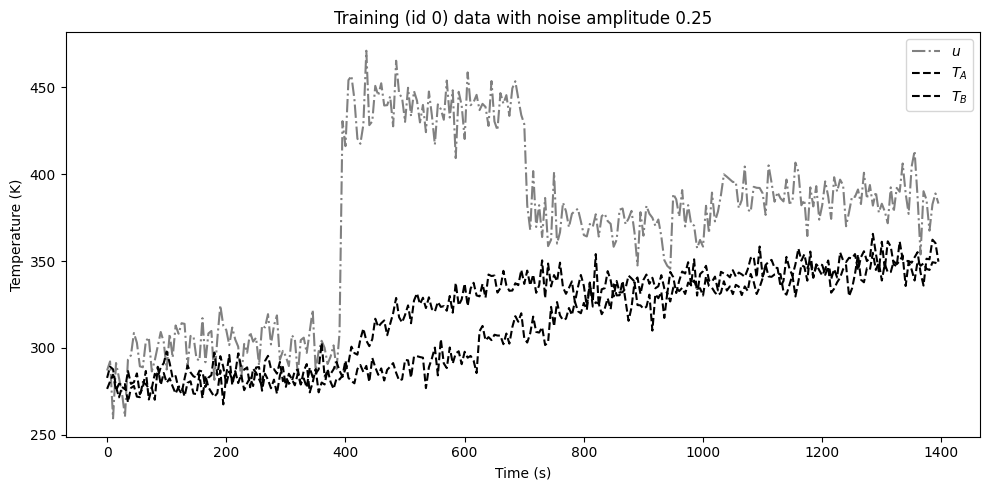

In [5]:
noise_amplitude = 0.25
use_indx = 0
_data = (
    data["train_norm"]
    .add_noise(noise_amplitude, jr.key(0))
    .denormalize(t_normalizer, y_normalizer, u_normalizer)[use_indx]
)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(_data.ts, _data.us, label=R"$u$", ls="-.", c="grey")
ax.plot(_data.ts, _data.ys, label=[R"$T_A$", R"$T_B$"], ls="--", c="black")
ax.legend()
ax.set(
    xlabel="Time (s)",
    ylabel="Temperature (K)",
    title=f"Training (id {use_indx}) data with noise amplitude {noise_amplitude}",
)
plt.tight_layout()
plt.show()

Plot the mean and standard deviation of the predictions

C:\Users\roth\AppData\Local\Temp\ipykernel_123032\2663636572.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(["model_type", "noise_amplitude"]).apply(


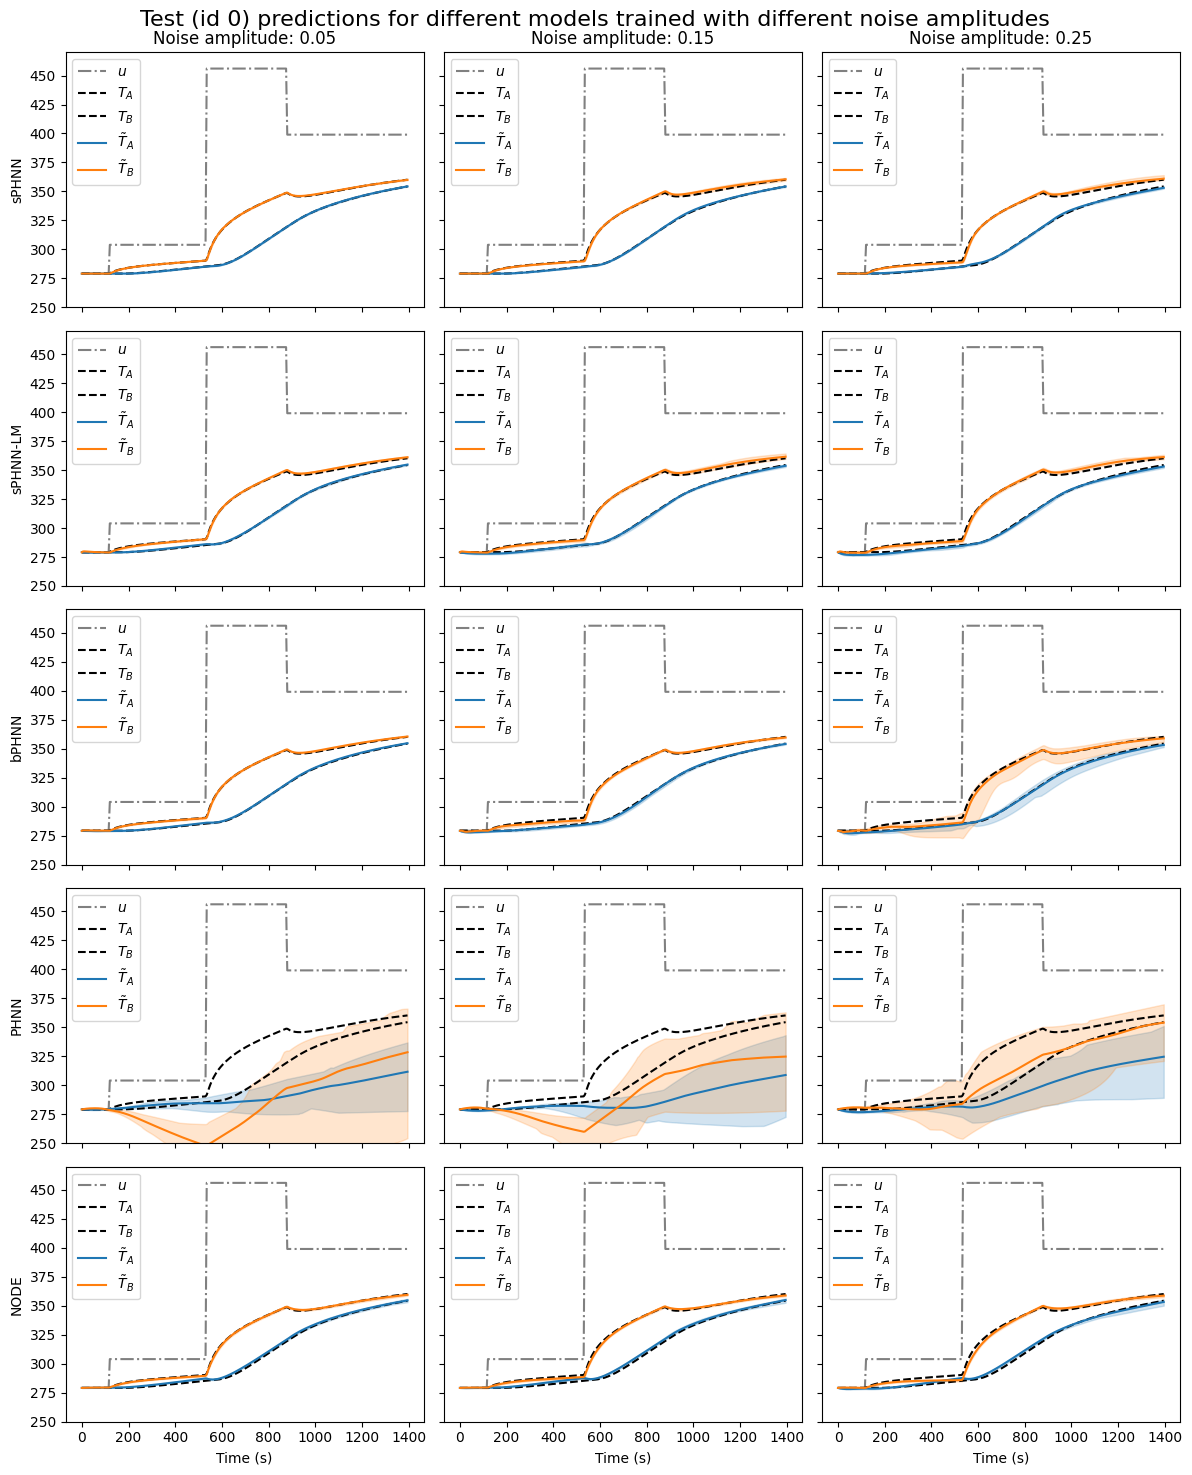

In [6]:
_data = data["test"][0]

df["prediction"] = df["wrapped_model"].apply(
    lambda fn: fn(_data.ts, _data.ys[0], _data.us)
)

def agg_preds(group):
    # Stack arrays into 2D array: shape (num_rows, length_of_prediction)
    stacked = np.stack(group["prediction"].values)
    statistics = get_statistics(stacked)
    return pd.Series(statistics)


grouped = df.groupby(["model_type", "noise_amplitude"]).apply(
    agg_preds, include_groups=False
)

model_types = grouped.index.get_level_values("model_type").unique()
noise_amps = grouped.index.get_level_values("noise_amplitude").unique()

fig, axes = plt.subplots(
    len(model_types),
    len(noise_amps),
    figsize=(4 * len(noise_amps), 3 * len(model_types)),
    sharex=True,
    sharey=True,
)
axes = np.atleast_2d(axes)

for i, model in enumerate(model_types):
    for j, noise in enumerate(noise_amps):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(f"Noise amplitude: {noise:.2f}")
        if j == 0:
            ax.set_ylabel(model)
        subset = grouped.loc[(model, noise)]
        ax.plot(_data.ts, _data.us, label=R"$u$", ls="-.", c="grey")
        ax.plot(_data.ts, _data.ys, label=[R"$T_A$", R"$T_B$"], ls="--", c="black")
        lines = ax.plot(
            _data.ts,
            subset["interquartile_mean"],
            label=[R"$\tilde T_A$", R"$\tilde T_B$"],
        )
        for k, line in zip([0, 1], lines):
            ax.fill_between(
                _data.ts,
                subset["first_quartile"][:, k],
                subset["third_quartile"][:, k],
                alpha=0.2,
                color=line.get_color(),
            )
        ax.legend()
        ax.set(xlabel="Time (s)")
        ax.set_ylim([250, 470])
        ax.label_outer()

fig.suptitle(
    "Test (id 0) predictions for different models trained with different noise amplitudes",
    fontsize=16,
)

plt.tight_layout()
plt.show()

Boxplot for test rmse

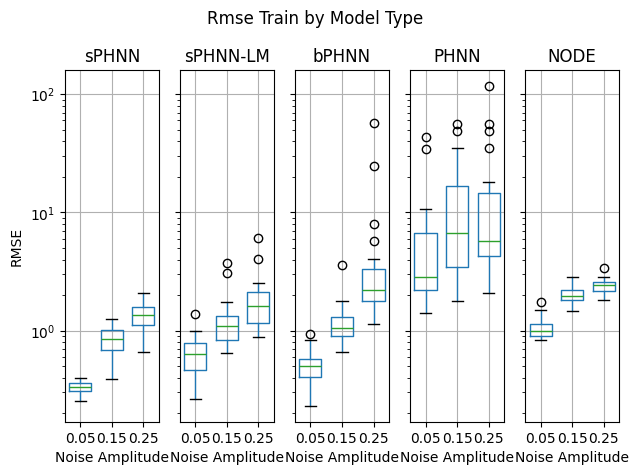

In [7]:
error_metric = "rmse_train"

_df = df[["model_type", "noise_amplitude", error_metric]]

model_types = _df["model_type"].cat.categories
noise_levels = sorted(_df["noise_amplitude"].unique())  # sort for consistent order

n_models = len(model_types)
fig, axes = plt.subplots(1, n_models, sharey=True)
axes = np.atleast_1d(axes)
for ax, model in zip(axes, model_types):
    _df[_df["model_type"] == model].boxplot(
        column=error_metric, by="noise_amplitude", ax=ax, widths=0.7
    )
    ax.set(
        title=model,
        xlabel="Noise Amplitude",
        ylabel="RMSE",
        yscale="log",
    )
    ax.label_outer()

fig.suptitle(f"{error_metric.replace('_', ' ').title()} by Model Type")
plt.tight_layout()
plt.show()